In [1]:
import sklearn
import sklearn.preprocessing
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from sklearn import metrics
import numpy as np
from IPython.display import display, HTML 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import GaussianNoise

RANDOM_SEED = 0
np.random.seed(RANDOM_SEED)

%matplotlib inline
from pandas.plotting import scatter_matrix

E:\Software\Anaconda3\envs\comp432-project\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
E:\Software\Anaconda3\envs\comp432-project\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
E:\Software\Anaconda3\envs\comp432-project\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
E:\Software\Anaconda3\envs\comp432-project\lib\site-

### Dataset Cleaning and reformat

In [2]:
data = pd.read_csv('data/PRSA_data_2010.1.1-2014.12.31.csv')
data.head(10)

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0
5,6,2010,1,1,5,NaN,-19,-10.0,1017.0,NW,16.10,0,0
6,7,2010,1,1,6,NaN,-19,-9.0,1017.0,NW,19.23,0,0
7,8,2010,1,1,7,NaN,-19,-9.0,1017.0,NW,21.02,0,0
8,9,2010,1,1,8,NaN,-19,-9.0,1017.0,NW,24.15,0,0
9,10,2010,1,1,9,NaN,-20,-8.0,1017.0,NW,27.28,0,0


In [3]:
data["timestamp"] = pd.to_datetime(data[["year", "month", "day", "hour"]])

In [4]:
data.drop(["No"], axis=1, inplace=True) 

In [5]:
data = data.set_index("timestamp")

In [6]:
# New index dataset
data.head(10)

,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
timestamp,,,,,,,,,,,,
2010-01-01 00:00:00,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0
2010-01-01 05:00:00,2010,1,1,5,NaN,-19,-10.0,1017.0,NW,16.10,0,0
2010-01-01 06:00:00,2010,1,1,6,NaN,-19,-9.0,1017.0,NW,19.23,0,0
2010-01-01 07:00:00,2010,1,1,7,NaN,-19,-9.0,1017.0,NW,21.02,0,0
2010-01-01 08:00:00,2010,1,1,8,NaN,-19,-9.0,1017.0,NW,24.15,0,0


In [7]:
# Shape
print(data.shape)

(43824, 12)


In [8]:
# Drop rows with NAN value 
data = data.dropna()
data.head(10)

,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
timestamp,,,,,,,,,,,,
2010-01-02 00:00:00,2010,1,2,0,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,2010,1,2,1,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,2010,1,2,2,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,2010,1,2,3,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,2010,1,2,4,138.0,-7,-5.0,1022.0,SE,6.25,2,0
2010-01-02 05:00:00,2010,1,2,5,109.0,-7,-6.0,1022.0,SE,7.14,3,0
2010-01-02 06:00:00,2010,1,2,6,105.0,-7,-6.0,1023.0,SE,8.93,4,0
2010-01-02 07:00:00,2010,1,2,7,124.0,-7,-5.0,1024.0,SE,10.72,0,0
2010-01-02 08:00:00,2010,1,2,8,120.0,-8,-6.0,1024.0,SE,12.51,0,0


In [9]:
# Shape
print(data.shape)

(41757, 12)


In [10]:
# Factorize String data
data.loc[:, 'cbwd'] = pd.factorize(data.loc[:, 'cbwd'])[0]
data.head(10)

,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
timestamp,,,,,,,,,,,,
2010-01-02 00:00:00,2010,1,2,0,129.0,-16,-4.0,1020.0,0,1.79,0,0
2010-01-02 01:00:00,2010,1,2,1,148.0,-15,-4.0,1020.0,0,2.68,0,0
2010-01-02 02:00:00,2010,1,2,2,159.0,-11,-5.0,1021.0,0,3.57,0,0
2010-01-02 03:00:00,2010,1,2,3,181.0,-7,-5.0,1022.0,0,5.36,1,0
2010-01-02 04:00:00,2010,1,2,4,138.0,-7,-5.0,1022.0,0,6.25,2,0
2010-01-02 05:00:00,2010,1,2,5,109.0,-7,-6.0,1022.0,0,7.14,3,0
2010-01-02 06:00:00,2010,1,2,6,105.0,-7,-6.0,1023.0,0,8.93,4,0
2010-01-02 07:00:00,2010,1,2,7,124.0,-7,-5.0,1024.0,0,10.72,0,0
2010-01-02 08:00:00,2010,1,2,8,120.0,-8,-6.0,1024.0,0,12.51,0,0


In [11]:
# Saved cleaned data
data.to_csv('data/cleaned_data')

### Data Static Summary

In [12]:
print(data.describe())

               year         month           day          hour         pm2.5  \
count  41757.000000  41757.000000  41757.000000  41757.000000  41757.000000   
mean    2012.042771      6.513758     15.685514     11.502311     98.613215   
std        1.415311      3.454199      8.785539      6.924848     92.050387   
min     2010.000000      1.000000      1.000000      0.000000      0.000000   
25%     2011.000000      4.000000      8.000000      5.000000     29.000000   
50%     2012.000000      7.000000     16.000000     12.000000     72.000000   
75%     2013.000000     10.000000     23.000000     18.000000    137.000000   
max     2014.000000     12.000000     31.000000     23.000000    994.000000   

               DEWP          TEMP          PRES          cbwd           Iws  \
count  41757.000000  41757.000000  41757.000000  41757.000000  41757.000000   
mean       1.750174     12.401561   1016.442896      1.201715     23.866747   
std       14.433658     12.175215     10.300733    

### Dataset Visualization

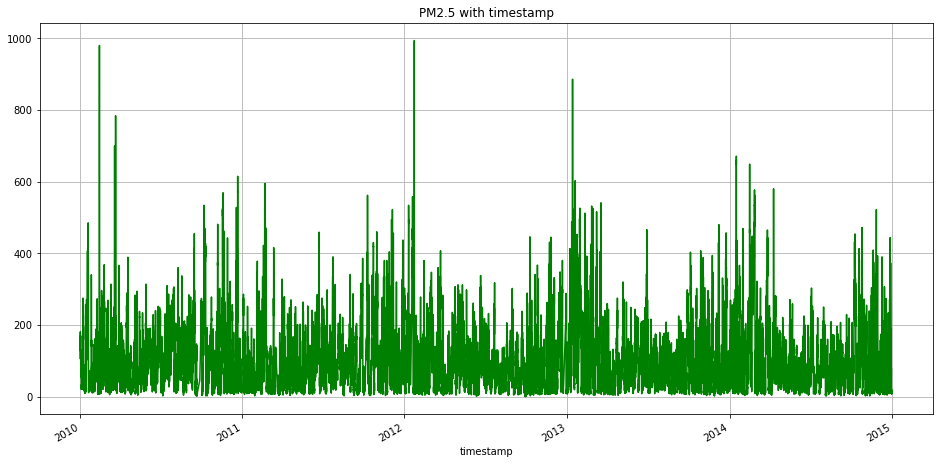

In [13]:
# Show how data looks like
plt.figure(figsize=[16, 8])
data['pm2.5'].plot(kind='line',color='green',grid=True)
plt.title("PM2.5 with timestamp");

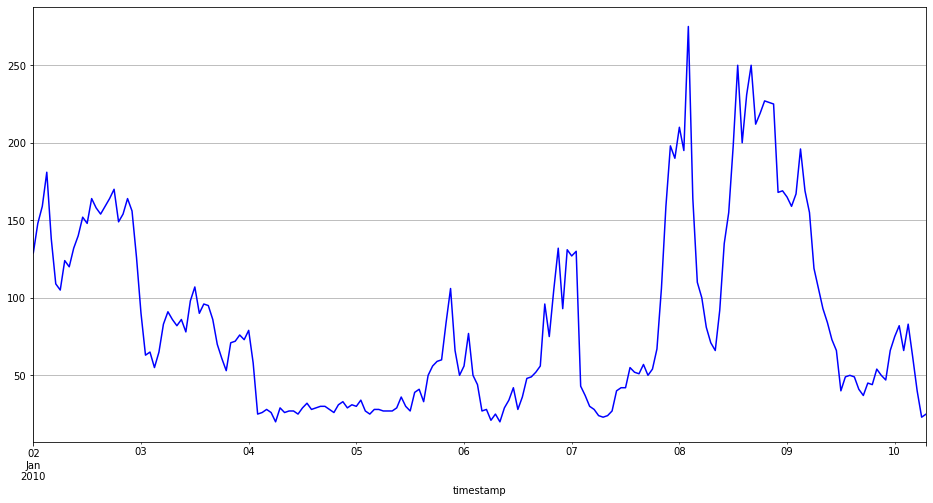

In [14]:
# Show one month zoom in pm2.5 data
plt.figure(figsize=[16, 8])
data['pm2.5'][:200].plot(kind='line',color='blue',grid=True);

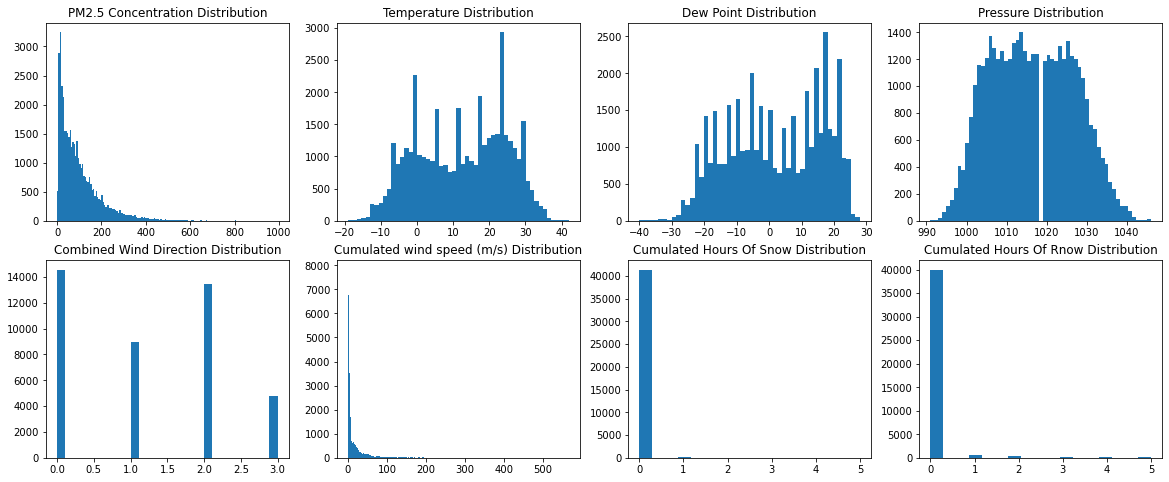

In [15]:
# Show data distribution
plt.figure(figsize=[20,8])
plt.subplot(2, 4, 1)
plt.hist(data['pm2.5'], bins='auto')
plt.title('PM2.5 Concentration Distribution')
plt.subplot(2, 4, 2)
plt.hist(data['TEMP'], bins='auto')
plt.title('Temperature Distribution')
plt.subplot(2, 4, 3)
plt.hist(data['DEWP'], bins='auto')
plt.title('Dew Point Distribution')
plt.subplot(2, 4, 4)
plt.hist(data['PRES'], bins='auto')
plt.title('Pressure Distribution')
plt.subplot(2, 4, 5)
plt.hist(data['cbwd'], bins='auto')
plt.title('Combined Wind Direction Distribution')
plt.subplot(2, 4, 6)
plt.hist(data['Iws'], bins='auto')
plt.title('Cumulated wind speed (m/s) Distribution')
plt.subplot(2, 4, 7)
plt.hist(data['Is'], bins='auto', range=[0,5])
plt.title('Cumulated Hours Of Snow Distribution')
plt.subplot(2, 4, 8)
plt.hist(data['Ir'], bins='auto', range=[0,5])
plt.title('Cumulated Hours Of Rnow Distribution');

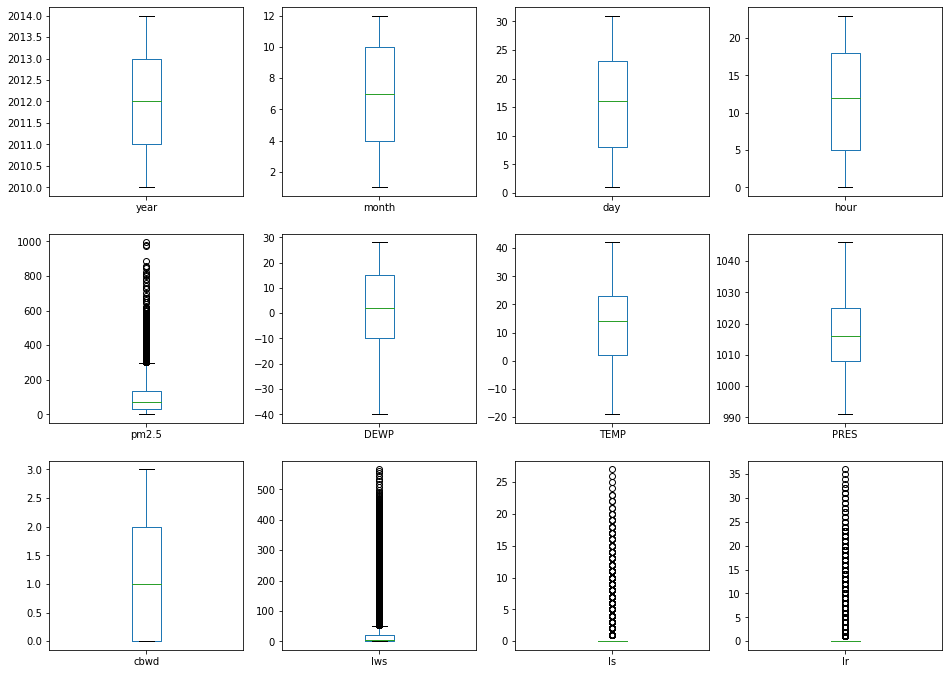

In [16]:
# Univariate plot
data.plot(kind='box', subplots=True, layout=(4,4), figsize=[16,16], sharex=False, sharey=False);

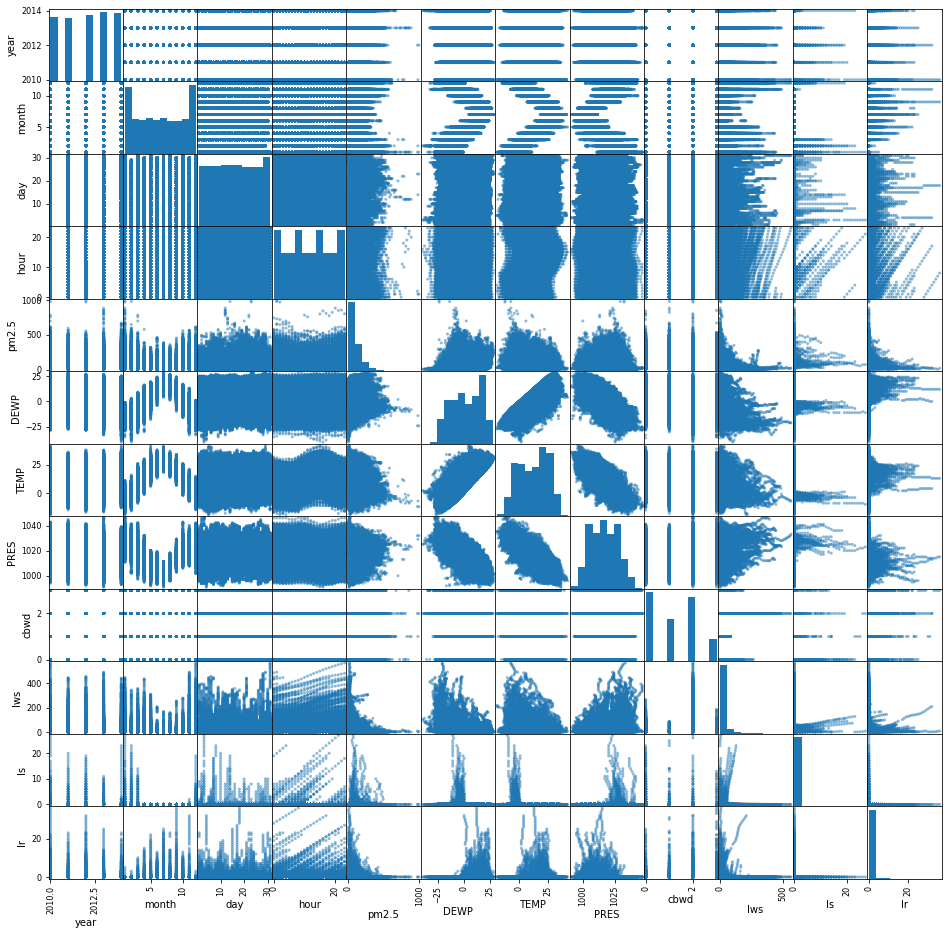

In [17]:
# Multivariate Plots
scatter_matrix(data,figsize=[16,16])
plt.show()

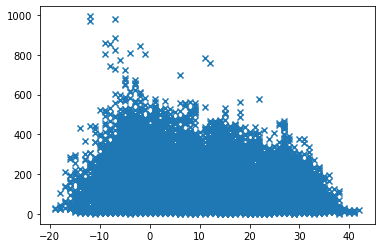

In [18]:
# Zoom in the relation between temp and pm2.5
plt.scatter(data['TEMP'], data['pm2.5'], marker= "x")

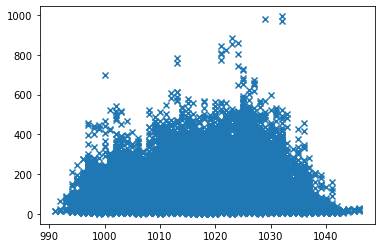

In [19]:
# Zoom in the relation between PRES and pm2.5
plt.scatter(data['PRES'], data['pm2.5'], marker= "x")

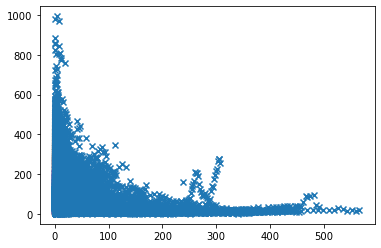

In [20]:
# Zoom in the relation between Iws and pm2.5
plt.scatter(data['Iws'], data['pm2.5'], marker= "x")

### Data Wrangling

In [21]:
# Sign a new column
data = data.assign(anom=pd.Series(np.zeros(len(data), dtype=np.int)).values)
data

,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,anom
timestamp,,,,,,,,,,,,,
2010-01-02 00:00:00,2010,1,2,0,129.0,-16,-4.0,1020.0,0,1.79,0,0,0
2010-01-02 01:00:00,2010,1,2,1,148.0,-15,-4.0,1020.0,0,2.68,0,0,0
2010-01-02 02:00:00,2010,1,2,2,159.0,-11,-5.0,1021.0,0,3.57,0,0,0
2010-01-02 03:00:00,2010,1,2,3,181.0,-7,-5.0,1022.0,0,5.36,1,0,0
2010-01-02 04:00:00,2010,1,2,4,138.0,-7,-5.0,1022.0,0,6.25,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,2014,12,31,19,8.0,-23,-2.0,1034.0,2,231.97,0,0,0
2014-12-31 20:00:00,2014,12,31,20,10.0,-22,-3.0,1034.0,2,237.78,0,0,0
2014-12-31 21:00:00,2014,12,31,21,10.0,-22,-3.0,1034.0,2,242.70,0,0,0


In [22]:
df25 = data.loc[:, 'pm2.5']
df25

timestamp
2010-01-02 00:00:00    129.0
2010-01-02 01:00:00    148.0
2010-01-02 02:00:00    159.0
2010-01-02 03:00:00    181.0
2010-01-02 04:00:00    138.0
                       ...  
2014-12-31 19:00:00      8.0
2014-12-31 20:00:00     10.0
2014-12-31 21:00:00     10.0
2014-12-31 22:00:00      8.0
2014-12-31 23:00:00     12.0
Name: pm2.5, Length: 41757, dtype: float64

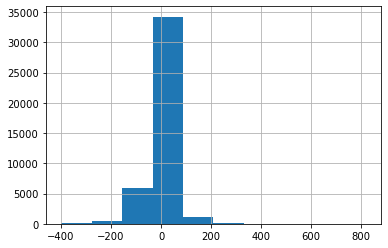

In [23]:
# Different rolling window for labeling
# Rolling window 12hrs
df25_12_column = df25 - df25.rolling(12).mean()
df25_12_column.name = 'diff_12hr_pm2.5'
df25_12_column.hist();

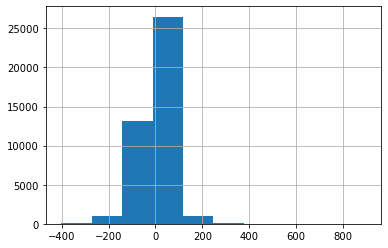

In [24]:
# Rolling window 24hrs
df25_24_column = df25 - df25.rolling(24).mean()
df25_24_column.name = 'diff_24hr_pm2.5'
df25_24_column.hist();

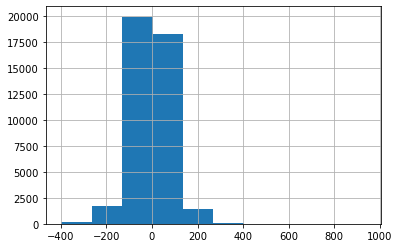

In [25]:
# Rolling window 48hrs
df25_48_column = df25 - df25.rolling(48).mean()
df25_48_column.name = 'diff_48hr_pm2.5'
df25_48_column.hist();

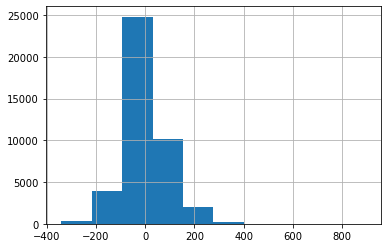

In [26]:
# Rolling window 144hrs
df25_144_column = df25 - df25.rolling(144).mean()
df25_144_column.name = 'diff_144hr_pm2.5'
df25_144_column.hist();

In [27]:
# Declear window list
window_list = [df25_12_column, df25_24_column, df25_48_column, df25_144_column]

In [28]:
df25_24_column

timestamp
2010-01-02 00:00:00         NaN
2010-01-02 01:00:00         NaN
2010-01-02 02:00:00         NaN
2010-01-02 03:00:00         NaN
2010-01-02 04:00:00         NaN
                         ...   
2014-12-31 19:00:00   -3.291667
2014-12-31 20:00:00   -0.625000
2014-12-31 21:00:00   -0.208333
2014-12-31 22:00:00   -2.208333
2014-12-31 23:00:00    1.958333
Name: diff_24hr_pm2.5, Length: 41757, dtype: float64

In [29]:
def get_new_dataframe_with_anomaly_label(original_dataset, window_column_series):
    newdata = pd.concat([data, window_column_series], axis=1)
    newdata.columns.values[-1] = 'diff_pm_2.5'
    newdata.loc[newdata['diff_pm_2.5'] >= 3*(newdata['diff_pm_2.5']).std(),'anom'] = 1
    plt.figure(figsize=(16,8))
    plt.plot(newdata['pm2.5'], markevery=newdata['anom']==1, marker='x', markeredgecolor='red', color='green',markersize=10)
    #print(newdata([newdata['anom']==1]).head(10))
    print('{0} total anomaly numbers : {1}'.format(window_column_series.name,len(newdata[newdata['anom']==1])))
    plt.title('Window size : {0}'.format(window_column_series.name))
    return newdata

In [34]:
newdata = pd.concat([data, df25_24_column], axis=1)
newdata

,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,anom,diff_24hr_pm2.5
timestamp,,,,,,,,,,,,,,
2010-01-02 00:00:00,2010,1,2,0,129.0,-16,-4.0,1020.0,0,1.79,0,0,0,NaN
2010-01-02 01:00:00,2010,1,2,1,148.0,-15,-4.0,1020.0,0,2.68,0,0,0,NaN
2010-01-02 02:00:00,2010,1,2,2,159.0,-11,-5.0,1021.0,0,3.57,0,0,0,NaN
2010-01-02 03:00:00,2010,1,2,3,181.0,-7,-5.0,1022.0,0,5.36,1,0,0,NaN
2010-01-02 04:00:00,2010,1,2,4,138.0,-7,-5.0,1022.0,0,6.25,2,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,2014,12,31,19,8.0,-23,-2.0,1034.0,2,231.97,0,0,0,-3.291667
2014-12-31 20:00:00,2014,12,31,20,10.0,-22,-3.0,1034.0,2,237.78,0,0,0,-0.625000
2014-12-31 21:00:00,2014,12,31,21,10.0,-22,-3.0,1034.0,2,242.70,0,0,0,-0.208333


In [32]:
# newdata.columns.values[-1] = 'diff_pm_2.5'
# newdata

,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,anom,diff_pm_2.5
timestamp,,,,,,,,,,,,,,
2010-01-02 00:00:00,2010,1,2,0,129.0,-16,-4.0,1020.0,0,1.79,0,0,0,NaN
2010-01-02 01:00:00,2010,1,2,1,148.0,-15,-4.0,1020.0,0,2.68,0,0,0,NaN
2010-01-02 02:00:00,2010,1,2,2,159.0,-11,-5.0,1021.0,0,3.57,0,0,0,NaN
2010-01-02 03:00:00,2010,1,2,3,181.0,-7,-5.0,1022.0,0,5.36,1,0,0,NaN
2010-01-02 04:00:00,2010,1,2,4,138.0,-7,-5.0,1022.0,0,6.25,2,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,2014,12,31,19,8.0,-23,-2.0,1034.0,2,231.97,0,0,0,-3.291667
2014-12-31 20:00:00,2014,12,31,20,10.0,-22,-3.0,1034.0,2,237.78,0,0,0,-0.625000
2014-12-31 21:00:00,2014,12,31,21,10.0,-22,-3.0,1034.0,2,242.70,0,0,0,-0.208333


In [32]:
# scatter_matrix(newdata,figsize=[16,16])
# plt.plot()

In [35]:
newdata.loc[newdata['diff_24hr_pm2.5'] >= 3*(newdata['diff_24hr_pm2.5']).std(),'anom'] = 1

In [36]:
newdata[newdata['anom'] == 1]

,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,anom,diff_24hr_pm2.5
timestamp,,,,,,,,,,,,,,
2010-01-08 02:00:00,2010,1,8,2,275.0,-20,-16.0,1031.0,3,0.89,0,0,1,190.166667
2010-01-14 01:00:00,2010,1,14,1,257.0,-20,-15.0,1025.0,3,2.67,0,0,1,204.250000
2010-01-16 03:00:00,2010,1,16,3,271.0,-16,-13.0,1035.0,3,0.89,0,0,1,194.541667
2010-01-26 20:00:00,2010,1,26,20,274.0,-11,-5.0,1020.0,3,0.89,0,0,1,200.583333
2010-01-26 21:00:00,2010,1,26,21,340.0,-13,-6.0,1020.0,2,1.79,0,0,1,253.375000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-09 15:00:00,2014,12,9,15,390.0,-8,0.0,1031.0,1,0.89,0,0,1,283.541667
2014-12-09 16:00:00,2014,12,9,16,375.0,-8,0.0,1031.0,1,1.78,0,0,1,253.625000
2014-12-09 17:00:00,2014,12,9,17,367.0,-8,0.0,1031.0,3,0.89,0,0,1,231.083333


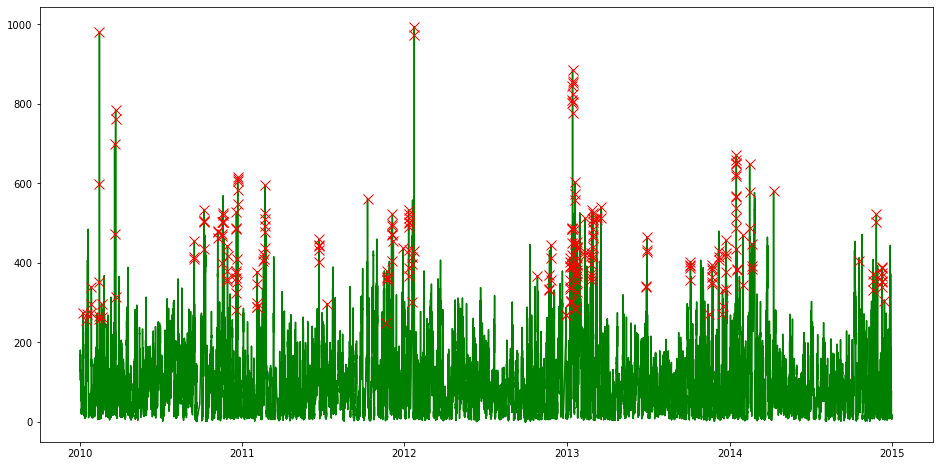

In [37]:
#Flag Anormalies
plt.figure(figsize=(16,8))
plt.plot(newdata['pm2.5'], markevery=newdata['anom']==1, marker='x', markeredgecolor='red', color='green',markersize=10)

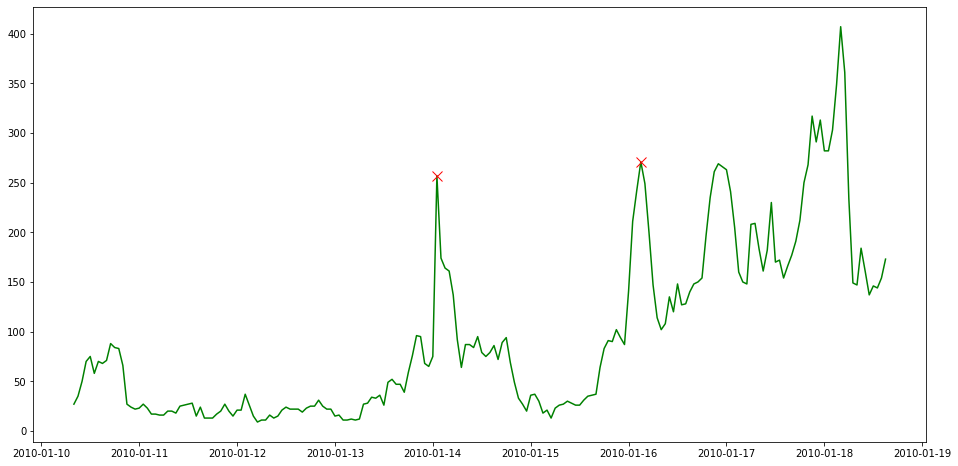

In [38]:
#Flag Anormalies
plt.figure(figsize=(16,8))
plt.plot(newdata['pm2.5'][200:400], markevery=newdata['anom'][200:400]==1, marker='x', markeredgecolor='red', color='green',markersize=10)

diff_12hr_pm2.5 total anomaly numbers : 262
diff_24hr_pm2.5 total anomaly numbers : 251
diff_48hr_pm2.5 total anomaly numbers : 263
diff_144hr_pm2.5 total anomaly numbers : 384


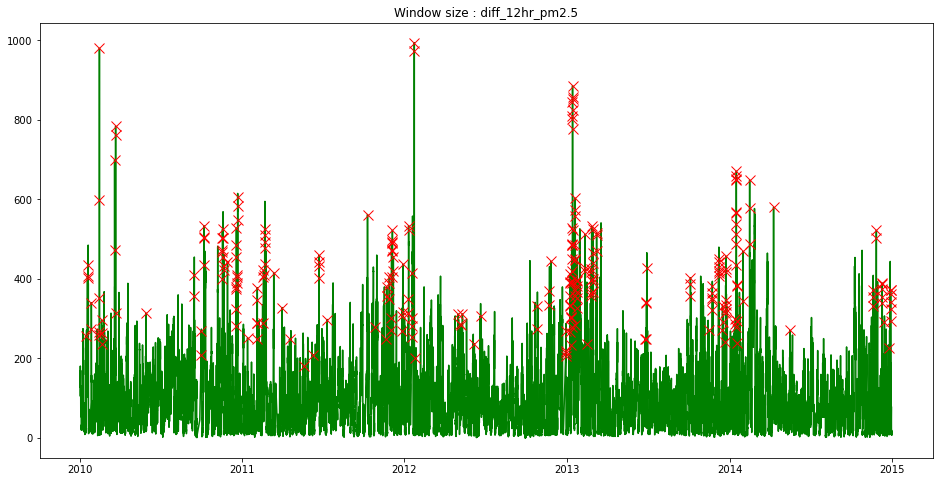

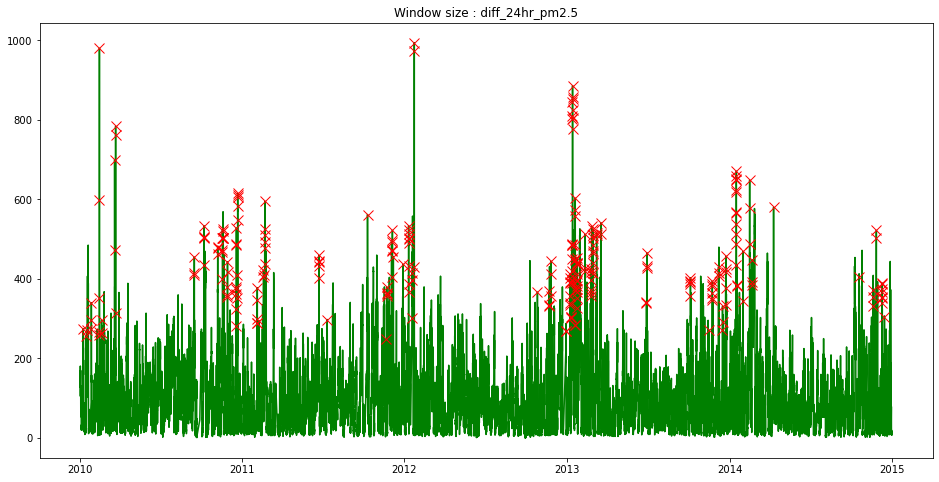

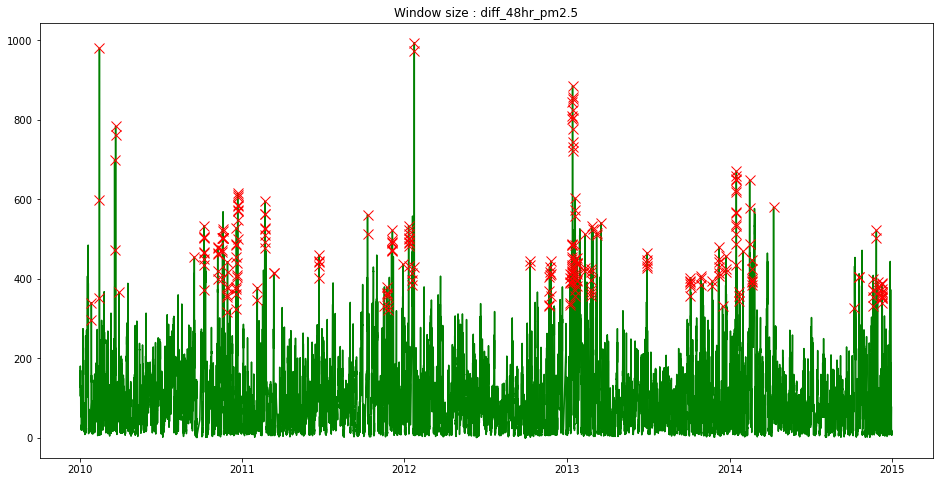

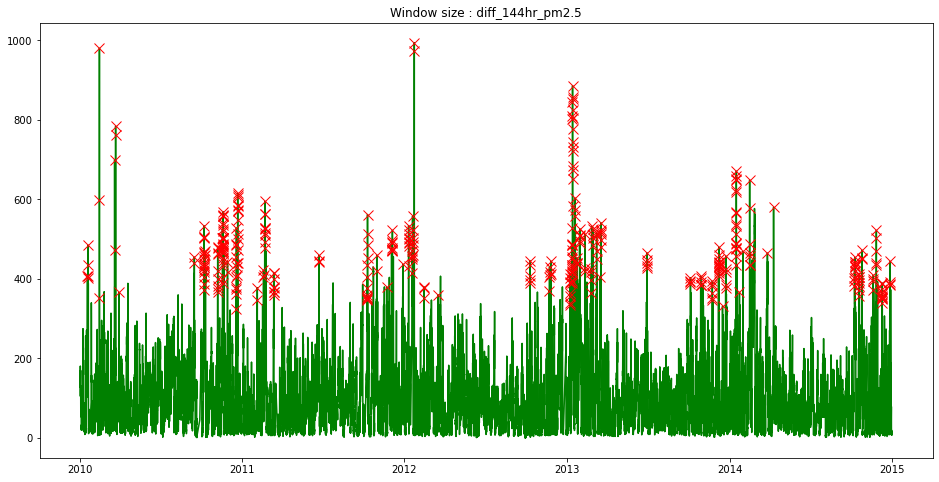

In [39]:
newdata_list = []
for i in window_list:
    #print(i)
    newdata_list.append(get_new_dataframe_with_anomaly_label(data, i))

In [40]:
# All 4 dataframe
newdata_list

[                     year  month  day  hour  pm2.5  DEWP  TEMP    PRES  cbwd  \
 timestamp                                                                      
 2010-01-02 00:00:00  2010      1    2     0  129.0   -16  -4.0  1020.0     0   
 2010-01-02 01:00:00  2010      1    2     1  148.0   -15  -4.0  1020.0     0   
 2010-01-02 02:00:00  2010      1    2     2  159.0   -11  -5.0  1021.0     0   
 2010-01-02 03:00:00  2010      1    2     3  181.0    -7  -5.0  1022.0     0   
 2010-01-02 04:00:00  2010      1    2     4  138.0    -7  -5.0  1022.0     0   
 ...                   ...    ...  ...   ...    ...   ...   ...     ...   ...   
 2014-12-31 19:00:00  2014     12   31    19    8.0   -23  -2.0  1034.0     2   
 2014-12-31 20:00:00  2014     12   31    20   10.0   -22  -3.0  1034.0     2   
 2014-12-31 21:00:00  2014     12   31    21   10.0   -22  -3.0  1034.0     2   
 2014-12-31 22:00:00  2014     12   31    22    8.0   -22  -4.0  1034.0     2   
 2014-12-31 23:00:00  2014  

In [ ]:
newdata.iloc[1:1000, :]['anom'].plot(kind='line',color='green')
plt.title("PM2.5 with timestamp")

In [ ]:
# Data Splitting
X_trn, X_tst, y_trn, y_tst = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=0)
print(len(X_trn))
X_trn, X_val, y_trn, y_val = sklearn.model_selection.train_test_split(X_trn, y_trn, test_size=0.2, random_state=1)
X_trn, X_val, X_tst, y_trn, y_val, y_tst
print(len(X_trn), len(y_trn))

In [ ]:
newdata = normalized_data
newdata

In [ ]:
# Nomalization for only training set or testing set
normalized_data=(data-data.mean())/data.std()

In [ ]:
newdata.iloc[900:1000, :]['pm2.5'].plot(kind='line',color='green')
plt.title("PM2.5 with timestamp")

In [ ]:
newdata.iloc[950:980, :]

In [ ]:
normal_mask = newdata['anom']==0
anomaly_mask = newdata['anom']==1
newdata.drop('anom',axis=1,inplace=True)
df_normal = newdata[normal_mask]
df_anomaly = newdata[anomaly_mask]

In [ ]:
df_normal.iloc[950:980, :]

In [ ]:
X_normal = df_normal.values
X_anomaly = df_anomaly.values

In [ ]:
X_normal

In [ ]:
from sklearn.model_selection import train_test_split

x_normal_train, x_normal_test = train_test_split(
    X_normal, test_size=0.25, random_state=0)

In [ ]:
model = Sequential()
model.add(Dense(5, input_dim=X_normal.shape[1], activation='relu'))
model.add(Dense(4, activation='relu')) # size to compress to
model.add(Dense(5, activation='relu'))
model.add(Dense(X_normal.shape[1])) # Multiple output neurons
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_normal_train,x_normal_train,verbose=1,epochs=100)

In [ ]:
# input_dim=X_normal.shape[1]
# hiden_dim = 5
# # first_hidden_layer_dim = 7
# # last_hidden_layer_dim = 7
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Dense(7, activation='elu', input_dim=X_normal.shape[1]), 
# #     tf.keras.layers.GaussianNoise(0.05),
#     tf.keras.layers.Dense(hiden_dim, activation='elu'),
#     tf.keras.layers.Dense(7, activation='elu')
# ])
# model.compile(loss='mean_squared_error', optimizer='adam')
# model.fit(x_normal_train,x_normal_train,verbose=1,epochs=40)

In [ ]:
pred1 = model.predict(x_normal_test)
score1 = np.sqrt(metrics.mean_squared_error(pred1,x_normal_test))
pred2 = model.predict(X_normal)
score2 = np.sqrt(metrics.mean_squared_error(pred2,X_normal))
pred3 = model.predict(X_anomaly)
score3 = np.sqrt(metrics.mean_squared_error(pred3,X_anomaly))
print(f"Out of Sample Normal Score (RMSE): {score1}")
print(f"Insample Normal Score (RMSE): {score2}")
print(f"Anomaly Underway Score (RMSE): {score3}")

In [ ]:
X_anomaly.shape

In [ ]:
x = range(221)
y1 = X_anomaly[:, 0]
y2 = pred3[:, 0]
plt.figure
plt.plot(x, y1, '-og');
plt.plot(x, y2, '-or')

In [ ]:
x = range(10000)
y1 = X_normal[:10000, 0]
y2 = pred2[:10000, 0]
plt.figure
plt.plot(x, y1, '-g');
plt.plot(x, y2, '-r');

In [ ]:
X_normal[0]

In [ ]:
pred2[0]